In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('npf_train.csv')

class2 = np.array(["event"]*df.shape[0],dtype="object")
class2[df["class4"]=="nonevent"] = "nonevent"
df["class2"] = class2
df["class2"] = df["class2"].astype("category")

not_needed_columns = ["partlybad", "id", "date"]
df = df.drop(not_needed_columns, axis=1)

class2_categories = {
    "nonevent": 0,
    "event": 1
}

class4_categories = {
    "nonevent": 0,
    "Ia": 1,
    "Ib": 2,
    "II": 3
}

def categorize_class2(row):
    row["class2"] = class2_categories[row["class2"]]
    
    return row
def categorize_class4(row):
    row["class4"] = class4_categories[row["class4"]]
    
    return row

df = df.apply(lambda row: categorize_class2(row), axis=1)
df = df.apply(lambda row: categorize_class4(row), axis=1)
df["class2"] = df["class2"].astype("category")
df["class4"] = df["class4"].astype("category")

In [3]:
X_df = df.loc[:, ~df.columns.isin(['class2', 'class4'])].copy()
Y_2 = df['class2'].copy()
Y_4 = df['class4'].copy()

X = X_df.values
y_2 = Y_2.values
y_4 = Y_4.values

In [4]:
X_df.shape

(458, 100)

In [56]:
df_test = pd.read_csv('./npf_test_hidden.csv')

# Unsupervised Analysis

## Data distribution

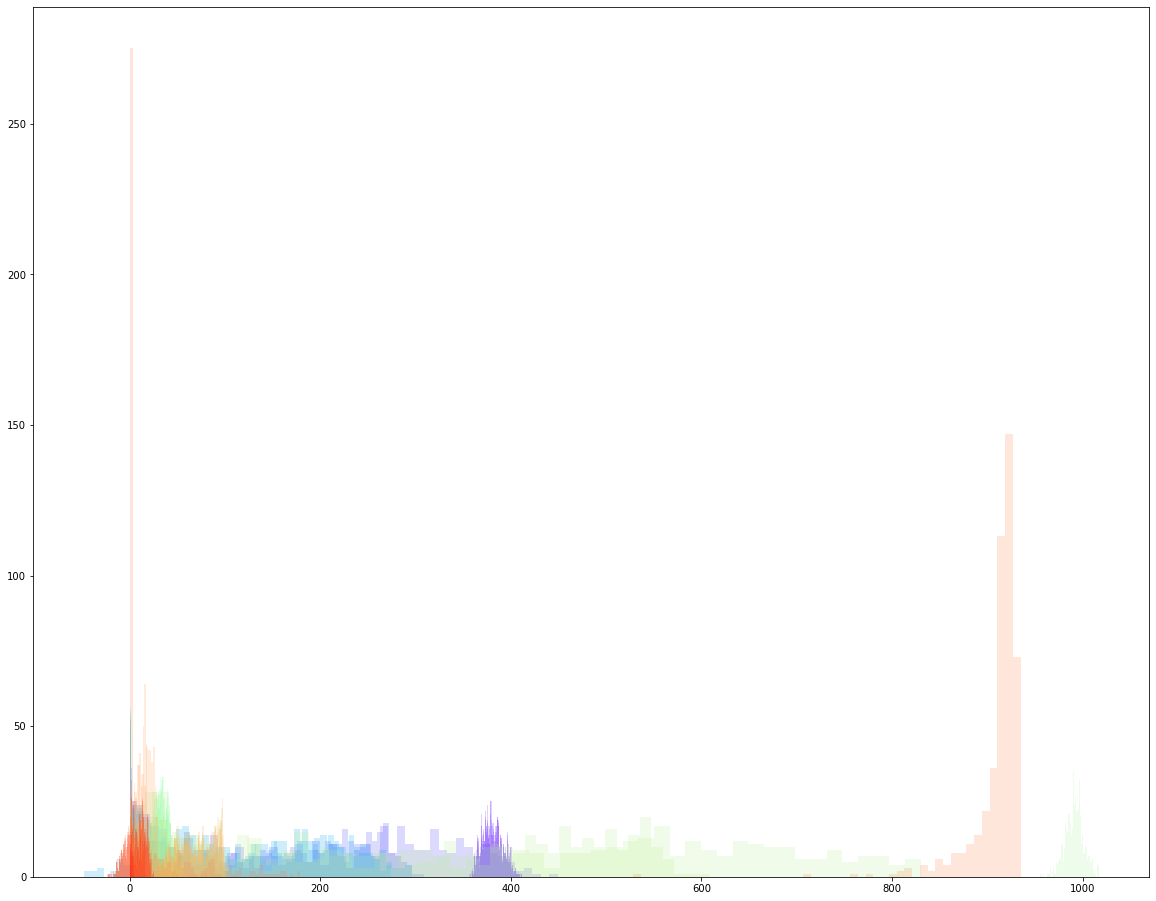

In [55]:
fig, ax = plt.subplots(figsize=(20, 16))
colors = {X_df.columns[i]:sns.color_palette('rainbow', 100)[i] for i in range(100)}
for col in X_df.columns:
    ax.hist(X_df[col], color=colors[col], bins=50, alpha=0.2)

## Data normalization

In [5]:
import sklearn.preprocessing

In [6]:
X_z = sklearn.preprocessing.StandardScaler().fit_transform(X)

## Feature correlation

In [7]:
R_pearson = pd.DataFrame(np.corrcoef(X_z, rowvar=False), index=X_df.columns, columns=X_df.columns)

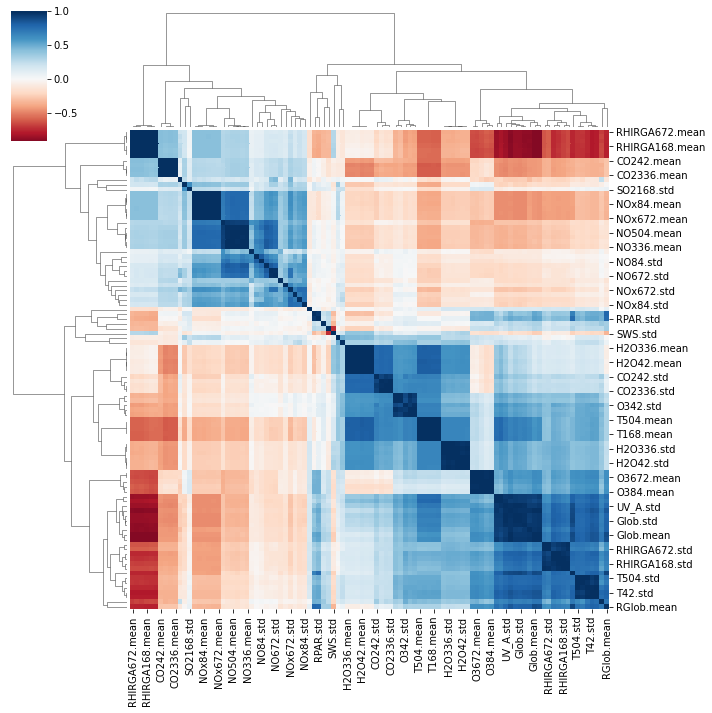

In [59]:
g_cluster = sns.clustermap(R_pearson, center=0, cmap='RdBu')

## PCA

In [8]:
import sklearn.decomposition

In [9]:
pca = sklearn.decomposition.PCA(n_components=10)

In [10]:
pca_results = pca.fit_transform(X_z)

In [11]:
pca_df = pd.DataFrame(pca_results[:, :2], columns=['pc_1', 'pc_2'])
pca_df.loc[:, 'class2'] = Y_2

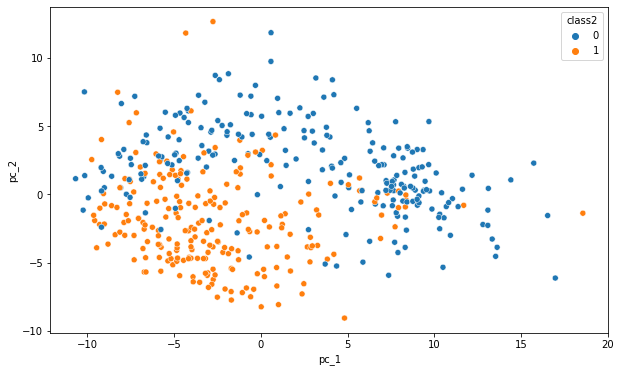

In [12]:
# class2 labels in terms of 2 PCs

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.scatterplot(x='pc_1', y='pc_2', hue='class2', data=pca_df, ax=ax)

Text(0, 0.5, 'Percentage of variance')

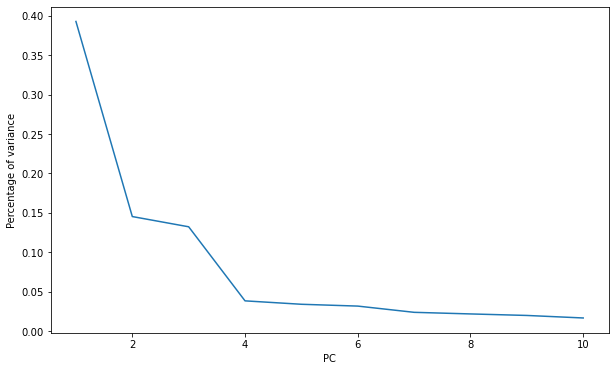

In [13]:
# percent of variance explained by each PCs

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(x=np.arange(10)+1, y=pca.explained_variance_ratio_, ax=ax)
ax.set_xlabel('PC')
ax.set_ylabel('Percentage of variance')

# Supervised Analysis

## Feature selection

### Feature importance score (SVM hyperparameter searching based on all 100 features)

In [20]:
import sklearn.model_selection
import sklearn.svm
import sklearn.inspection

from sklearn.experimental import enable_halving_search_cv

In [69]:
idx_test = np.random.default_rng(2).choice(np.arange(X.shape[0]), 50, replace=False)
idx_train = np.array(list(set(np.arange(X.shape[0])) - set(idx_test)))

In [74]:
svm = sklearn.svm.SVC(random_state=2)

param_grid = {
                'C':10.0**np.arange(-5, 6),
                'kernel':['poly', 'rbf', 'sigmoid'],
                'degree':np.arange(1, 11),
              }

param_search = sklearn.model_selection.HalvingGridSearchCV(svm, param_grid, random_state=2)\
                        .fit(X_z[idx_train, :], y_2[idx_train, ])

In [75]:
param_search.best_params_

{'C': 1.0, 'degree': 1, 'kernel': 'rbf'}

In [76]:
svm_b = sklearn.svm.SVC(C=1, kernel='poly', degree=1, random_state=2)
svm_b.fit(X_z[idx_train, :], y_2[idx_train, ])

SVC(C=1, degree=1, kernel='poly', random_state=2)

In [78]:
print('Test accuracy: ', svm_b.score(X_z[idx_test, :], y_2[idx_test, ]))

Test accuracy:  0.88


In [79]:
feature_importance_search = sklearn.inspection.permutation_importance(
                                svm_b, X_z[idx_train, :], y_2[idx_train, ], n_repeats=100, n_jobs=4)

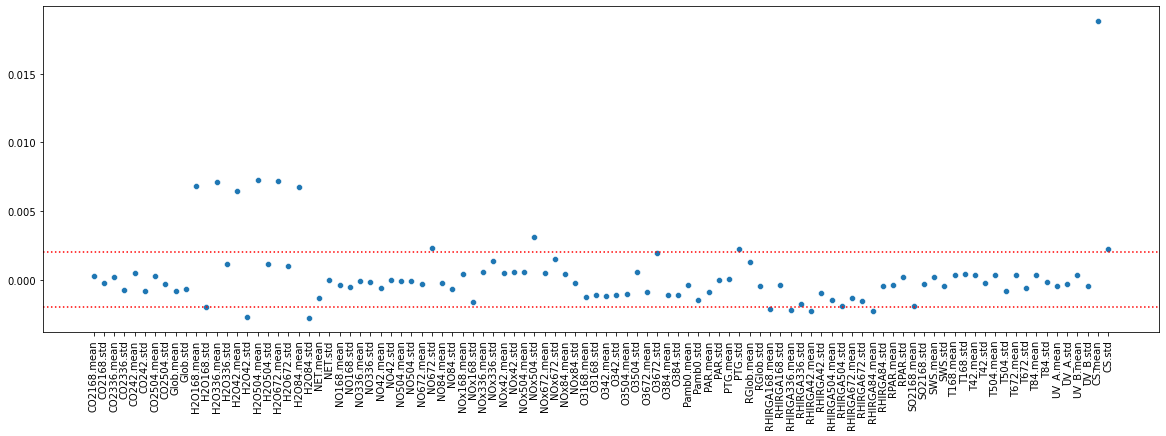

In [96]:
fig, ax = plt.subplots(figsize=(20, 6))
ax = sns.scatterplot(x=X_df.columns, y=feature_importance_search.importances_mean, ax=ax)
ax.tick_params(axis='x', labelrotation=90)
ax.axhline(0.002, c='r', ls=':')
ax.axhline(-0.002, c='r', ls=':')

In [97]:
selected_features_pi = X_df.columns[np.where(np.abs(feature_importance_search.importances_mean) > 0.002)]
selected_features_idx_pi = np.where(np.abs(feature_importance_search.importances_mean) > 0.002)[0]

In [132]:
print('Selected features: ', selected_features_pi)

Selected features:  Index(['H2O168.mean', 'H2O168.std', 'H2O336.mean', 'H2O42.mean', 'H2O42.std',
       'H2O504.mean', 'H2O672.mean', 'H2O84.mean', 'H2O84.std', 'NO672.std',
       'NOx504.std', 'PTG.std', 'RHIRGA168.mean', 'RHIRGA336.mean',
       'RHIRGA42.mean', 'RHIRGA84.mean', 'CS.mean', 'CS.std'],
      dtype='object')


In [124]:
svm_s = sklearn.svm.SVC(random_state=2)

param_grid_s = {
                'C':10.0**np.arange(-5, 6),
                'kernel':['poly', 'rbf', 'sigmoid'],
                'degree':np.arange(1, 11),
              }

param_search_s = sklearn.model_selection.HalvingGridSearchCV(svm_s, param_grid_s, random_state=2)\
                        .fit(X_z[idx_train, :][:, selected_features_idx_pi], y_2[idx_train, ])

In [126]:
print('Best params: ', param_search_s.best_params_)
print('Best score: ', param_search_s.best_score_)

Best params:  {'C': 10.0, 'degree': 10, 'kernel': 'rbf'}
Best score:  0.8376190476190477


In [127]:
svm_sb = sklearn.svm.SVC(C=10, kernel='rbf', random_state=2)
print('Test accuracy: ', svm_sb.fit(X_z[idx_train, :][:, selected_features_idx_pi], y_2[idx_train, ])\
                          .score(X_z[idx_test, :][:, selected_features_idx_pi], y_2[idx_test,]))

Test accuracy:  0.9


### L1 feature selection

In [105]:
import sklearn.feature_selection

In [108]:
feature_selection_lsvc = sklearn.feature_selection.SelectFromModel(
                            estimator=sklearn.svm.LinearSVC(C=1, penalty='l1', dual=False, max_iter=10**5), )\
                            .fit(X_z[idx_train, :], y_2[idx_train, ])

In [121]:
# Selected features

selected_features_l1 = feature_selection_lsvc.get_feature_names_out(X_df.columns)
selected_features_idx_l1 = np.array([list(X_df.columns).index(i) for i in selected_features_l1])

In [129]:
svm_l1 = sklearn.svm.SVC(random_state=2)

param_grid_l1 = {
                'C':10.0**np.arange(-5, 6),
                'kernel':['poly', 'rbf', 'sigmoid'],
                'degree':np.arange(1, 11),
              }

param_search_l1 = sklearn.model_selection.HalvingGridSearchCV(svm_l1, param_grid_l1, random_state=2)\
                        .fit(X_z[idx_train, :][:, selected_features_idx_l1], y_2[idx_train, ])

In [130]:
print('Best params: ', param_search_l1.best_params_)
print('Best score: ', param_search_l1.best_score_)

Best params:  {'C': 1.0, 'degree': 1, 'kernel': 'poly'}
Best score:  0.8373015873015873


In [131]:
svm_l1_b = sklearn.svm.SVC(C=1, kernel='poly', degree=1, random_state=2)
print('Test accuracy: ', svm_sb.fit(X_z[idx_train, :][:, selected_features_idx_l1], y_2[idx_train, ])\
                          .score(X_z[idx_test, :][:, selected_features_idx_l1], y_2[idx_test,]))

Test accuracy:  0.84


## Train the model with selected features

In [133]:
svm_f = sklearn.svm.SVC(C=10, kernel='rbf', random_state=2)
svm_f.fit(X_z[:, selected_features_idx_pi], y_2)

SVC(C=10, random_state=2)

In [134]:
svm_f.score(X_z[:, selected_features_idx_pi], y_2)

0.925764192139738

# Post analysis

In [144]:
X_sel = X_df[selected_features_pi].copy()
R_sel = pd.DataFrame(np.corrcoef(X_sel, rowvar=False), index=X_sel.columns, columns=X_sel.columns)

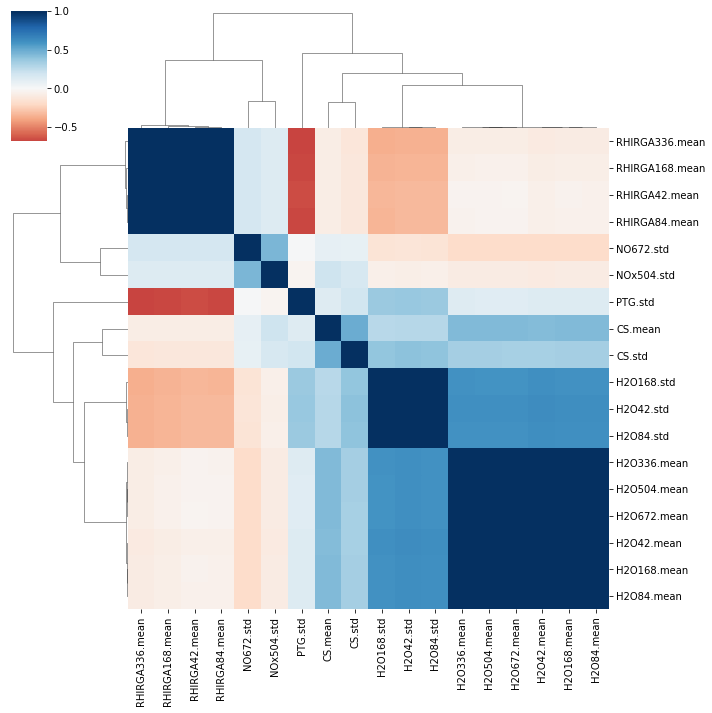

In [145]:
sns.clustermap(R_sel, center=0, cmap='RdBu')

In [148]:
# CV to get the accuracy on all data

svm_f = sklearn.svm.SVC(C=10, kernel='rbf', random_state=2)
accuracy = sklearn.model_selection.cross_val_score(svm_f, X_z[:, selected_features_idx_pi], y_2, cv=10)
accuracy

array([0.82608696, 0.84782609, 0.80434783, 0.76086957, 0.80434783,
       0.82608696, 0.89130435, 0.95652174, 0.91111111, 0.84444444])

In [149]:
print('Average accuracy: ', np.mean(accuracy))

Average accuracy:  0.8472946859903383
